<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | Model

# Diabetic Retinopathy<a id='top'></a> 

## Imports

In [109]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import pandas as pd
import pickle
import PIL
import random
import seaborn as sns
import shutil
import sklearn as sk
import tensorflow as tf
import warnings
import zipfile

from glob import glob
from tensorflow import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image as IMG
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical

from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Num GPUs Available:  1
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


In [ ]:
# # https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)

Code adapted from [github/PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sandralparedes","key":"746c1c655d0796973a3d3552fbcc97a5"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# assign to directory 
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [5]:
# download dataset from kaggle
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

diabetic-retinopathy-2015-data-colored-resized.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# unzip kaggle file
zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [7]:
# show number of classes and images
source_images_path = '/tmp/colored_images/colored_images/'
extracted_directories_path = os.listdir(source_images_path)

for image_directory in extracted_directories_path:
  print(image_directory, len(os.listdir(os.path.join(source_images_path, image_directory))))

Severe 873
Moderate 5292
Proliferate_DR 708
No_DR 25810
Mild 2443


## 2 | Exploratory Data Analysis

In [15]:
# read in files and diagnosis label and store as dataframe

filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}

for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'colored_images':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                dataframe['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                dataframe['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(dataframe)  
dataframe.info()
dataframe.head(2)

Severe
Proliferate_DR
No_DR
Mild
Moderate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


,image_path,diagnosis
0,/tmp/colored_images/colored_images/Severe/9001_right.png,Severe
1,/tmp/colored_images/colored_images/Severe/34571_left.png,Severe


Data set n = 35,126

In [ ]:
# distribution of five diagnosis classes in order of severity of disease

plt.figure(figsize=(15,6))
sns.barplot(dataframe.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


Classes are unbalanced

In [ ]:
# view one healthy eye image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")

print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


In [ ]:
# view one proliferate DR image (most advanced stage of disease)

path = '/tmp/colored_images/colored_images/Proliferate_DR/10017_left.png'

proliferate_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Proliferate Diabetic Retinopthy')
print('Datatype:', type(proliferate_image))
proliferate_image 


## Validation Split

In [8]:
# set up for train/test split
# DO NOT RUN # 
# shutil.rmtree('/tmp/raw_data/train/')

# To re-run uncomment here

temp_path = '/tmp'
raw_data_dir_name = 'raw_data'

train_data_dir_name = 'train'
test_data_dir_name = 'test'
raw_data_directories = [train_data_dir_name, test_data_dir_name]

images_path =  os.path.join(temp_path, raw_data_dir_name)
tmp_directories = os.listdir(temp_path)

def build_raw_data_directory(parent, directory):
  dir_path = os.path.join(parent, directory)
  os.mkdir(dir_path)
  for dir in extracted_directories_path:
    os.mkdir(os.path.join(dir_path, dir))

if raw_data_dir_name not in tmp_directories:
  os.mkdir(images_path)
  for directory in raw_data_directories:
    build_raw_data_directory(images_path, directory)
else:
  print(raw_data_dir_name, " already exist")
  images_path_directories = os.listdir(images_path)
  for directory in raw_data_directories:
    if directory not in images_path_directories:
      build_raw_data_directory(images_path, directory)




raw_data  already exist


In [9]:
# # split data into train/test folders

# # To re-run uncomment here
distribution = 0.2

raw_data_path = os.path.join(temp_path, raw_data_dir_name)
test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

data_dirs = os.listdir(source_images_path)

for dir in data_dirs:
  path = os.path.join(source_images_path, dir)
  test_data_path = os.path.join(test_data_path_root, dir)
  train_data_path = os.path.join(train_data_path_root, dir)
  images = os.listdir(path)
  print(path, test_data_path)
  for image in images:
    random_number = random.uniform(0, 1)
    is_test_image = random_number < distribution
    source_image_path = os.path.join(path, image)
    # shutil.copy(src, dst)
    if is_test_image:
      shutil.copy(source_image_path, test_data_path)
      # print(source_image_path, "goes to test", test_data_path)
    else:
      shutil.copy(source_image_path, train_data_path)
      # print(source_image_path, "goes to train", train_data_path)

test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

test_dirs = os.listdir(test_data_path_root)
train_dirs = os.listdir(train_data_path_root)

for dir in test_dirs:
  path = os.path.join(test_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

for dir in train_dirs:
  path = os.path.join(train_data_path_root, dir)
  files = os.listdir(path) #/tmp/raw_data/train/Severe
  print(path, len(files))

/tmp/colored_images/colored_images/Severe /tmp/raw_data/test/Severe
/tmp/colored_images/colored_images/Moderate /tmp/raw_data/test/Moderate
/tmp/colored_images/colored_images/Proliferate_DR /tmp/raw_data/test/Proliferate_DR
/tmp/colored_images/colored_images/No_DR /tmp/raw_data/test/No_DR
/tmp/colored_images/colored_images/Mild /tmp/raw_data/test/Mild
/tmp/raw_data/test/Severe 314
/tmp/raw_data/test/Moderate 1923
/tmp/raw_data/test/Proliferate_DR 249
/tmp/raw_data/test/No_DR 9426
/tmp/raw_data/test/Mild 870
/tmp/raw_data/train/Severe 845
/tmp/raw_data/train/Moderate 5073
/tmp/raw_data/train/Proliferate_DR 689
/tmp/raw_data/train/No_DR 24766
/tmp/raw_data/train/Mild 2352


In [21]:
original_raw_data_path = '/tmp/raw_data'
raw_data_copy = '/tmp/raw_data_small'
# shutil.copytree(original_raw_data_path, raw_data_copy)
raw_data_copy_test_path = '/tmp/raw_data_small/test'
raw_data_copy_train_path = '/tmp/raw_data_small/train'

paths_to_reduce_images = [raw_data_copy_test_path, raw_data_copy_train_path]

for path in paths_to_reduce_images:
  dir_names = os.listdir(path)
  for dir_name in dir_names:
    images_path = os.path.join(path, dir_name)
    files = os.listdir(images_path)
    for index, file in enumerate(files):
      if index >= 200:
        file_path = os.path.join(images_path, file)
        os.remove(file_path)



# Logistic Regression

### Code adapted from [sdblass](https://github.com/sdblass/Metis_coursework/blob/master/6_Deep_Learning/2_baseline_model.ipynb)

In [88]:
root = '/tmp/raw_data_small/train'

In [89]:
retinas = os.listdir(root)
retinas = [retina for retina in retinas if retina[0]!='.']


In [90]:
# # convert image to 1D vector
test_img_path = os.listdir(root+f'/{retinas[0]}')[0]
test_img_path = root+f'/{retinas[0]}' + f'/{test_img_path}'
test_img = Image.open(test_img_path)

In [91]:
# num pixels

dimension = np.array(test_img).reshape(-1).shape[0]
dimension

150528

In [92]:
# num images

def image_count(num_diagnoses, root): 
  num_images = 0
  for i, retina in enumerate(retinas):
    if i == num_diagnoses: break
    num_images += len(os.listdir(root + f'/{retina}'))
  return num_images

In [93]:
# num files in raw_data_small; 5 classes (diagnoses) 
image_count(5, root) 

1000

In [94]:
# initialize 2D matrix with dimensions equal to num of images times num of pixels
image_repo = np.zeros([image_count(5, root), dimension])
image_repo

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
def img_vectorization(num_diagnoses, root):
  image_repo = np.zeros([image_count(num_diagnoses, root), dimension])
  count = 0
  diagnosis = []
  for i, retina in enumerate(retinas):
    images = os.listdir(root + f'/{retina}')
    for image in images:
      img = Image.open(root + f'/{retina}' + f'/{image}')
      row = np.array(img).reshape(-1)
      image_repo[count, :] = row
      diagnosis.append(retina)
      img.close()
      count += 1
    if i == num_diagnoses - 1: 
      return image_repo, diagnosis
  return image_repo, diagnosis

# print(image_repo.shape)


In [99]:
result, diagnosis = img_vectorization(5, root)

In [100]:
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [101]:
result.shape

(1000, 150528)

In [102]:
len(diagnosis)

1000

In [103]:
# test data

root_test = '/tmp/raw_data_small/test'
result_test, diagnosis_test = img_vectorization(5, root_test)

In [108]:
print(result_test)
print(result_test.shape)
print(len(diagnosis_test))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 150528)
1000


In [113]:
# truncated SVD

scaler = StandardScaler()
X_train = scaler.fit_transform(result)
X_test = scaler.transform(result_test)

type(X_train)

numpy.ndarray

In [115]:
svd = TruncatedSVD(n_components=2)

result_2d = svd.fit_transform(X_train)
result_test_2d = svd.transform(X_test)

In [117]:
print('result_2d', result_2d.shape)
print('result_test_2d', result_test_2d.shape)

result_2d (1000, 2)
result_test_2d (1000, 2)


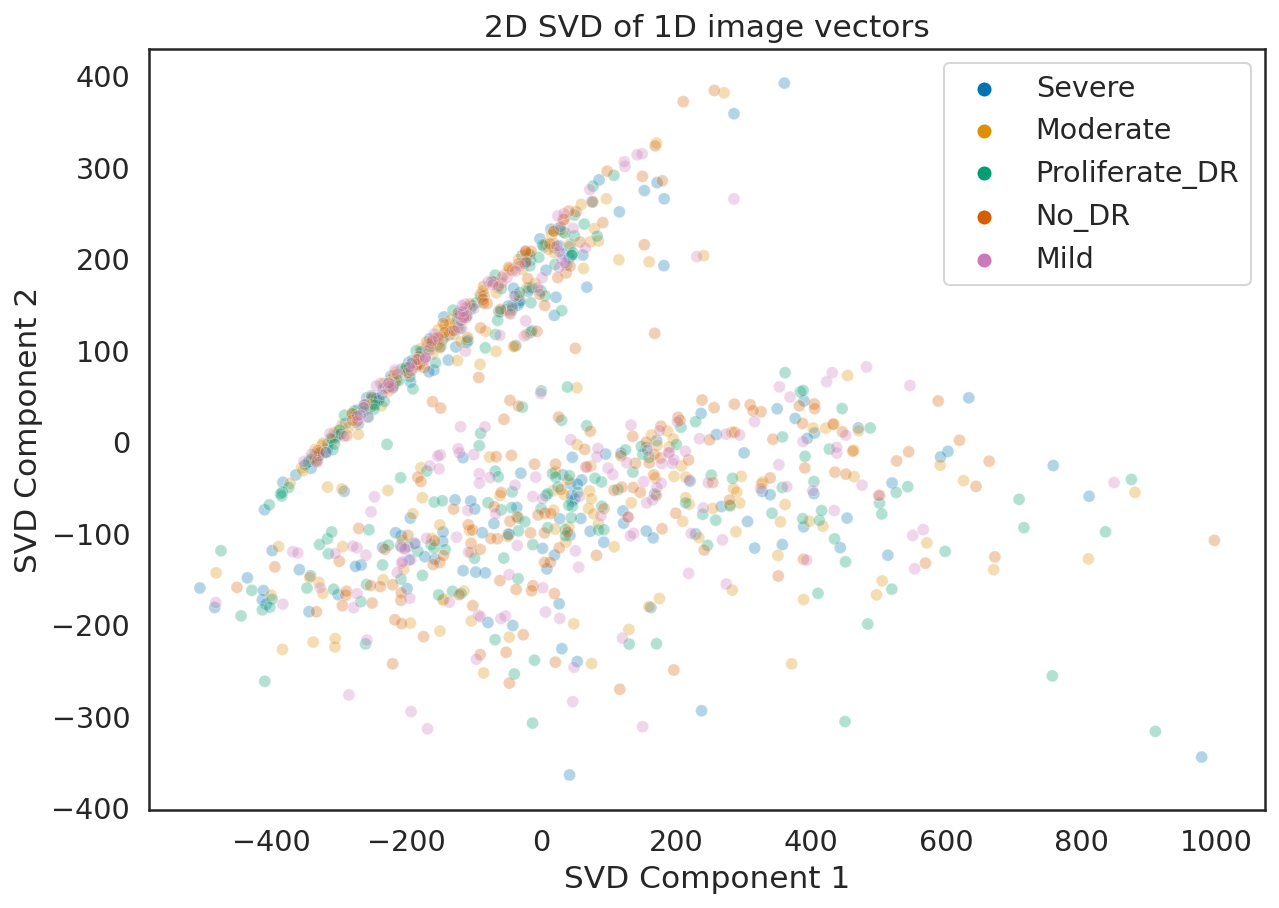

In [118]:
# Adapted from NeuralNet_Features_TransferLearning.ipynb from Metis
sns.set(style='white', rc={"figure.figsize":(10, 7)}, font_scale=1.3)
sns.scatterplot(x=result_2d[:, 0], y=result_2d[:, 1],
                hue=diagnosis, alpha=.3,
                palette=sns.color_palette("colorblind", 5))
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D SVD of 1D image vectors");
plt.legend(loc='upper right');

In [121]:
baseline_lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
baseline_lr.fit(result_2d, diagnosis)


LogisticRegression(multi_class='multinomial')

In [124]:
score = baseline_lr.score(result_test_2d, diagnosis_test)
print('Logistic Regresion Baseline Score = ', score)

Logistic Regresion Baseline Score =  0.227


### Code adapted from [ngoodby](https://github.com/ngoodby/Metis-Deep-Learning-Project/blob/master/model_creation.ipynb)

In [27]:
class_names = ['Proliferate_DR', 'Mild','No_DR', 'Severe', 'Moderate']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
size = (224,224)
num_classes = len(class_names)

In [ ]:
def load_data(class_names):
    
    datasets = ['/tmp/raw_data/train', 
                '/tmp/raw_data/test']
    output = []
    
    # Iterate through training and test set folders
    for dataset in datasets:

        images = []
        labels = []
        folders = os.listdir(dataset)
        folders = [value for value in folders if value != ".DS_Store"]
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in folders:
            label = class_names_label[folder]
            
            # Iterate through each image in the folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the image
                image = cv2.imread(img_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 image = cv2.resize(image, size) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = None)
        labels = np.array(labels, dtype = None)   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data(class_names)

Loading /tmp/raw_data/train


100%|██████████| 4231/4231 [00:04<00:00, 866.73it/s]


Loading /tmp/raw_data/test


100%|██████████| 1061/1061 [00:01<00:00, 905.58it/s]


In [ ]:
train_images = train_images.flatten()
print('train images type:', type(train_images))
print('train images shape:', train_images.shape)

train images type: <class 'numpy.ndarray'>
train images shape: (4223213568,)


In [ ]:
test_images = test_images.flatten()
print('test images type:', type(test_images))
print('test images shape:', test_images.shape)

test images type: <class 'numpy.ndarray'>
test images shape: (1064232960,)


### Code adapted from [PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)

In [ ]:
def img_to_array(img_path):
    img=  IMG.load_img(img_path,target_size=[150,150])
    x = IMG.img_to_array(img)
    return x

In [ ]:
filepath = 'work_data'

work_data_df = {'image_path':[],'category':[],'class':[]}

for class_ in os.listdir(filepath):
    if class_ != '.DS_Store':  
        for category in os.listdir(filepath +"/"+class_):
            if category != '.DS_Store':        
                for image in os.listdir(filepath +"/"+class_ +"/"+category):
                    if image != '.DS_Store':
                        work_data_df['image_path'].append(filepath +"/"+class_+"/"+category+"/"+ image)
                        work_data_df['category'].append(category)
                        work_data_df['class'].append(class_)
work_data_df = pd.DataFrame(work_data_df)    
work_data_df.head()

In [ ]:
work_data_df.to_csv('work_data_df')


In [ ]:
X_train = []
X_val = []
X_test = []

data_train = work_data_df[work_data_df['class'] == 'train']
y_train = data_train.category.astype("category").cat.codes
y_train_hotcode = keras.utils.to_categorical(y_train)
for index in data_train.index:
    X_train.append(img_to_array(data_train.loc[index,'image_path']))
    
data_val = work_data_df[work_data_df['class'] == 'validation']
y_val = data_val.category.astype("category").cat.codes
y_val_hotcode = keras.utils.to_categorical(y_train)
for index in data_val.index:
    X_val.append(img_to_array(data_val.loc[index,'image_path']))    
    
data_test = work_data_df[work_data_df['class'] == 'test']
y_test = data_test.category.astype("category").cat.codes
y_test_hotcode = keras.utils.to_categorical(y_test)
for index in data_test.index:
    X_test.append(img_to_array((data_test.loc[index,'image_path'])))   
    
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
### Save X_digit, y_digit
image_data_array = (X_train, X_test,X_val,y_train,y_test,y_val)
with open('image_data_array.pickle','wb') as file:
    pickle.dump(image_data_array,file)

In [ ]:
print(f"We have {len(X_train)} train dataset")
print(f"We have {len(X_val)} train dataset")
print(f"We have {len(X_test)} test dataset")

In [ ]:
global category_map
category_int_map = dict(zip(data_train.category,y_train))
int_category_map = dict(zip(y_train,data_train.category))
int_category_map

In [ ]:
category_int_map


# 3 | Deep Learning Model

### Deep Learning First Model

Code source: https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d 

In [ ]:
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/raw_data/train',  
        target_size=(150, 150), 
        batch_size=batch_size,
        class_mode='binary')  

validation_generator = test_datagen.flow_from_directory(
        '/tmp/raw_data/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 28095 images belonging to 5 classes.
Found 7031 images belonging to 5 classes.


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size
        )

model.save_weights('first_try.h5')  

Epoch 1/5
125/125 [==============================] - 15s 118ms/step - loss: -214507824.0000 - accuracy: 0.1370 - val_loss: -578096064.0000 - val_accuracy: 0.1825
Epoch 2/5
125/125 [==============================] - 14s 114ms/step - loss: -2003340928.0000 - accuracy: 0.1605 - val_loss: -4200994304.0000 - val_accuracy: 0.1275
Epoch 3/5
125/125 [==============================] - 15s 117ms/step - loss: -8443093504.0000 - accuracy: 0.1550 - val_loss: -14637317120.0000 - val_accuracy: 0.1587
Epoch 4/5
125/125 [==============================] - 14s 112ms/step - loss: -26486697984.0000 - accuracy: 0.1581 - val_loss: -39455670272.0000 - val_accuracy: 0.1625
Epoch 5/5
125/125 [==============================] - 14s 111ms/step - loss: -64640176128.0000 - accuracy: 0.1530 - val_loss: -94855258112.0000 - val_accuracy: 0.1550
